In [1]:
import numpy as np
import tensorflow.compat.v1 as tf

from open_spiel.python import rl_environment
from open_spiel.python.pytorch import dqn as dqn_pt
from open_spiel.python.algorithms import dqn
from open_spiel.python.algorithms import random_agent

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
checkpoint_dir = "/tmp/dqn_test"
num_train_episodes = 10000
eval_every = 100

hidden_layers_sizes = [64, 64]
replay_buffer_capacity = int(1e5)
batch_size = 32

In [3]:
def eval_against_random_bots(env, trained_agents, random_agents, num_episodes):
  """Evaluates `trained_agents` against `random_agents` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = random_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agents_output = [
              agent.step(time_step, is_evaluation=True) for agent in cur_agents
          ]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [4]:
def pt_main(checkpoint_dir,
         num_train_episodes,
         eval_every,
         hidden_layers_sizes,
         replay_buffer_capacity,batch_size):
  game = "breakthrough"
  num_players = 2

  env_configs = {"columns": 5, "rows": 5}
  env = rl_environment.Environment(game, **env_configs)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  # random agents for evaluation
  random_agents = [
      random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
      for idx in range(num_players)
  ]


  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  # pylint: disable=g-complex-comprehension
  agents = [
      dqn_pt.DQN(
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
  ]
  result = []
  for ep in range(num_train_episodes):
    if (ep + 1) % eval_every == 0:
      r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
      result.append(r_mean)
      print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if env.is_turn_based:
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
      else:
        agents_output = [agent.step(time_step) for agent in agents]
        action_list = [agent_output.action for agent_output in agents_output]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)
  return result

In [5]:
pt_result = pt_main(checkpoint_dir,
                    num_train_episodes,
                    eval_every,
                    hidden_layers_sizes,
                    replay_buffer_capacity,batch_size)

[100] Mean episode rewards [0.046 0.416]


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[200] Mean episode rewards [0.088 0.094]
[300] Mean episode rewards [ 0.142 -0.046]
[400] Mean episode rewards [ 0.184 -0.054]
[500] Mean episode rewards [ 0.136 -0.028]
[600] Mean episode rewards [ 0.11  -0.052]
[700] Mean episode rewards [ 0.148 -0.096]
[800] Mean episode rewards [ 0.04  -0.056]
[900] Mean episode rewards [0.12  0.036]
[1000] Mean episode rewards [0.046 0.054]
[1100] Mean episode rewards [0.124 0.044]
[1200] Mean episode rewards [0.198 0.064]
[1300] Mean episode rewards [0.14 0.24]
[1400] Mean episode rewards [0.38  0.196]
[1500] Mean episode rewards [0.634 0.314]
[1600] Mean episode rewards [0.692 0.384]
[1700] Mean episode rewards [0.67  0.496]
[1800] Mean episode rewards [0.812 0.62 ]
[1900] Mean episode rewards [0.648 0.636]
[2000] Mean episode rewards [0.762 0.754]
[2100] Mean episode rewards [0.646 0.668]
[2200] Mean episode rewards [0.748 0.586]
[2300] Mean episode rewards [0.57  0.702]
[2400] Mean episode rewards [0.584 0.616]
[2500] Mean episode rewards [0.6

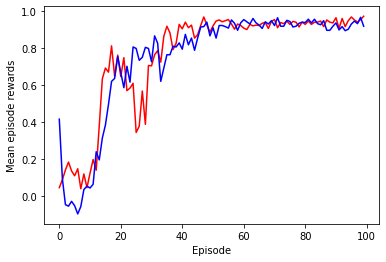

In [18]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(pt_result))]
pt_r_mean0 = [y[0] for y in pt_result]
pt_r_mean1 = [y[1] for y in pt_result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

In [10]:
def tf_main(checkpoint_dir,
            num_train_episodes,
            eval_every,
            hidden_layers_sizes,
            replay_buffer_capacity,batch_size):
  game = "breakthrough"
  num_players = 2

  env_configs = {"columns": 5, "rows": 5}
  env = rl_environment.Environment(game, **env_configs)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  # random agents for evaluation
  random_agents = [
      random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
      for idx in range(num_players)
  ]

  with tf.Session() as sess:
    hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
    # pylint: disable=g-complex-comprehension
    agents = [
        dqn.DQN(
            session=sess,
            player_id=idx,
            state_representation_size=info_state_size,
            num_actions=num_actions,
            hidden_layers_sizes=hidden_layers_sizes,
            replay_buffer_capacity=replay_buffer_capacity,
            batch_size=batch_size) for idx in range(num_players)
    ]
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    
    result_tf = []
    for ep in range(num_train_episodes):
      if (ep + 1) % eval_every == 0:
        r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
        result_tf.append(r_mean)
        print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

      time_step = env.reset()
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = agents[player_id].step(time_step)
          action_list = [agent_output.action]
        else:
          agents_output = [agent.step(time_step) for agent in agents]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)

      # Episode is over, step all agents with final info state.
      for agent in agents:
        agent.step(time_step)
  return result_tf

In [11]:
result_tf = tf_main(checkpoint_dir,
                    num_train_episodes,
                    eval_every,
                    hidden_layers_sizes,
                    replay_buffer_capacity,batch_size)

[100] Mean episode rewards [0.494 0.146]
[200] Mean episode rewards [0.468 0.018]
[300] Mean episode rewards [ 0.386 -0.04 ]
[400] Mean episode rewards [ 0.232 -0.052]
[500] Mean episode rewards [ 0.188 -0.016]
[600] Mean episode rewards [0.108 0.078]
[700] Mean episode rewards [ 0.096 -0.012]
[800] Mean episode rewards [0.064 0.044]
[900] Mean episode rewards [-0.046  0.008]
[1000] Mean episode rewards [-0.114  0.024]
[1100] Mean episode rewards [-0.112 -0.028]
[1200] Mean episode rewards [-0.062 -0.086]
[1300] Mean episode rewards [-0.092 -0.048]
[1400] Mean episode rewards [-0.106 -0.03 ]
[1500] Mean episode rewards [-0.066 -0.074]
[1600] Mean episode rewards [-0.094 -0.128]
[1700] Mean episode rewards [-0.036 -0.064]
[1800] Mean episode rewards [ 0.006 -0.092]
[1900] Mean episode rewards [ 0.092 -0.044]
[2000] Mean episode rewards [ 0.226 -0.116]
[2100] Mean episode rewards [ 0.54  -0.018]
[2200] Mean episode rewards [ 0.578 -0.124]
[2300] Mean episode rewards [ 0.46  -0.084]
[2400

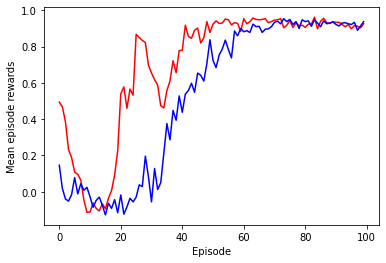

In [19]:
ep = [x for x in range(len(result_tf))]
tf_r_mean0 = [y[0] for y in result_tf]
tf_r_mean1 = [y[1] for y in result_tf]

plt.plot(ep,tf_r_mean0, c='red')
plt.plot(ep,tf_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()

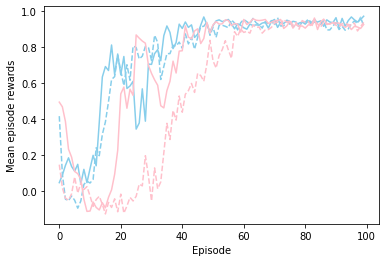

In [16]:
plt.plot(ep,pt_r_mean0, c='skyblue')
plt.plot(ep,pt_r_mean1, c='skyblue', linestyle='dashed')
plt.plot(ep,tf_r_mean0, c='pink')
plt.plot(ep,tf_r_mean1, c='pink', linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Mean episode rewards')
plt.show()